<a href="https://colab.research.google.com/github/Arnobzzz/Inverter-RL-agent/blob/main/inverter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("--- Installing Dependencies ---")
!pip install gymnasium stable-baselines3[extra] torch tensorboard -q
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from tensorboard.backend.event_processing import event_accumulator
from gymnasium import spaces # Import spaces for defining observation space

--- Installing Dependencies ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 11.4 MB/s eta 0:00:00


In [2]:
# Save the controller classes to a Python file
%%writefile controllers.py
import numpy as np
import torch

class SPWMController:
    """A simple open-loop controller with a fixed modulation index."""
    def __init__(self, modulation_index=0.8):
        self.m = modulation_index
    def get_modulation_index(self, t):
        return self.m

class PIController:
    """A standard Proportional-Integral (PI) controller."""
    def __init__(self, Kp, Ki, target_rms, ac_freq=50.0):
        self.Kp = Kp
        self.Ki = Ki
        self.target_rms = target_rms
        self.ac_period = 1.0 / ac_freq
        self.integral_error = 0.0
        self.m = 0.8 # Initial modulation index

    def update_modulation_index(self, v_c_history_tensor):
        if v_c_history_tensor.numel() < 2: return
        measured_rms = torch.sqrt(torch.mean(v_c_history_tensor**2))
        error = self.target_rms - measured_rms.item()
        self.integral_error += error * self.ac_period
        self.integral_error = np.clip(self.integral_error, -10.0, 10.0)
        self.m = (self.Kp * error) + (self.Ki * self.integral_error)
        self.m = np.clip(self.m, 0.0, 1.0)

    def get_modulation_index(self, t):
        return self.m

Writing controllers.py


In [3]:
# Save the InverterModelGPU class to a Python file
%%writefile inverter_model_gpu.py
import numpy as np
import torch
# Removed solve_ivp as it's not used in this version and might cause import issues
# from scipy.integrate import solve_ivp

class InverterModelGPU:
    """
    A high-fidelity, FULLY GPU-ACCELERATED model of a single-phase H-bridge inverter.
    """
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.R_esr_L = torch.tensor(0.1, device=device, dtype=torch.float32)
        self.R_esr_C = torch.tensor(0.05, device=device, dtype=torch.float32)
        self.L = torch.tensor(1.5e-3, device=device, dtype=torch.float32)
        self.C = torch.tensor(10e-6, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq
        self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    # Using a simple step function instead of batch_step_rk4 for this script's structure
    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on

        # Custom RK4 Solver Step
        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        self.sim_time += dt
        return self.state

Writing inverter_model_gpu.py


In [4]:
# Save the InverterEnvGPU class to a Python file
%%writefile rl_environment_gpu.py
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
from inverter_model_gpu import InverterModelGPU # Import from the file saved above

class InverterEnvGPU(gym.Env):
    """A GPU-accelerated Gymnasium environment for the inverter."""
    def __init__(self, device): # Accept device here
        super().__init__()
        self.device = device # Use the passed device
        self.inverter = InverterModelGPU(device=self.device) # Use the class defined above
        self.ac_period = 1.0 / self.inverter.ac_freq.item()
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Observation: [V_rms, I_rms, Power, PF, THD] - Shape (5,)
        self.observation_space = spaces.Box(low=-500.0, high=500.0, shape=(5,), dtype=np.float32)

        self.max_steps = 100
        self.current_step = 0

    def _get_obs_from_gpu(self, v_history_gpu, i_history_gpu):
        if v_history_gpu.numel() < 2:
            return torch.zeros(5, device=self.device, dtype=torch.float32)

        v_rms = torch.sqrt(torch.mean(v_history_gpu**2))
        i_rms = torch.sqrt(torch.mean(i_history_gpu**2))
        power = torch.mean(v_history_gpu * i_history_gpu)
        pf = power / (v_rms * i_rms + 1e-6)

        fft = torch.fft.fft(v_history_gpu)
        # Handle case where fft might be short
        if fft.numel() > 10:
            harmonics = torch.abs(fft[1:11]) # Look at fundamental + 10 harmonics
            fundamental = harmonics[0]
            higher_harmonics = torch.sqrt(torch.sum(harmonics[1:]**2))
            thd = higher_harmonics / (fundamental + 1e-6)
        else:
            thd = torch.tensor(1.0, device=self.device, dtype=torch.float32) # Assume high distortion


        obs = torch.stack([v_rms, i_rms, power, pf, thd])
        obs[~torch.isfinite(obs)] = 0.0
        # Ensure obs is shape (5,)
        if obs.shape != (5,):
             # Pad with zeros if necessary (shouldn't happen with correct stacking)
             padded_obs = torch.zeros(5, device=self.device, dtype=torch.float32)
             padded_obs[:obs.numel()] = obs
             obs = padded_obs


        return obs


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device, dtype=torch.float32)
        # Initial observation (zeros as no history yet), ensure it's on the correct device and shape (5,)
        obs = torch.zeros(5, device=self.device, dtype=torch.float32) # Initialize with 5 zeros
        return obs.cpu().numpy(), {} # Return numpy array for SB3 compatibility

    def step(self, action):
        modulation_index = torch.tensor((action[0] + 1.0) / 2.0, device=self.device, dtype=torch.float32)

        v_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)
        i_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)


        for i in range(self.sim_steps_per_cycle):
            # Pass load_resistance as a scalar tensor
            state_gpu = self.inverter.step(modulation_index, self.load_resistance, 1e-5) # Use constant dt
            i_hist_gpu[i], v_hist_gpu[i] = state_gpu[0], state_gpu[1]

        obs_gpu = self._get_obs_from_gpu(v_hist_gpu, i_hist_gpu)
        v_rms, _, _, _, thd = obs_gpu # Unpack 5 elements

        target_v_rms = 30.0
        voltage_error = torch.abs(target_v_rms - v_rms)
        reward = -(voltage_error**2) * 5.0 - (thd**2)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        return obs_gpu.cpu().numpy(), reward.item(), done, False, {}

Writing rl_environment_gpu.py


In [5]:
# Save the controller classes to a Python file
%%writefile controllers.py
import numpy as np
import torch

class SPWMController:
    """A simple open-loop controller with a fixed modulation index."""
    def __init__(self, modulation_index=0.8):
        self.m = modulation_index
    def get_modulation_index(self, t):
        return self.m

class PIController:
    """A standard Proportional-Integral (PI) controller."""
    def __init__(self, Kp, Ki, target_rms, ac_freq=50.0):
        self.Kp = Kp
        self.Ki = Ki
        self.target_rms = target_rms
        self.ac_period = 1.0 / ac_freq
        self.integral_error = 0.0
        self.m = 0.8 # Initial modulation index

    def update_modulation_index(self, v_c_history_tensor):
        if v_c_history_tensor.numel() < 2: return
        measured_rms = torch.sqrt(torch.mean(v_c_history_tensor**2))
        error = self.target_rms - measured_rms.item()
        self.integral_error += error * self.ac_period
        self.integral_error = np.clip(self.integral_error, -10.0, 10.0)
        self.m = (self.Kp * error) + (self.Ki * self.integral_error)
        self.m = np.clip(self.m, 0.0, 1.0)

    def get_modulation_index(self, t):
        return self.m

Overwriting controllers.py


In [6]:
# Save the InverterModelGPU class to a Python file
%%writefile inverter_model_gpu.py
import numpy as np
import torch
# Removed solve_ivp as it's not used in this version and might cause import issues
# from scipy.integrate import solve_ivp

class InverterModelGPU:
    """
    A high-fidelity, FULLY GPU-ACCELERATED model of a single-phase H-bridge inverter.
    """
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.R_esr_L = torch.tensor(0.1, device=device, dtype=torch.float32)
        self.R_esr_C = torch.tensor(0.05, device=device, dtype=torch.float32)
        self.L = torch.tensor(1.5e-3, device=device, dtype=torch.float32)
        self.C = torch.tensor(10e-6, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq
        self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    # Using a simple step function instead of batch_step_rk4 for this script's structure
    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on

        # Custom RK4 Solver Step
        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        self.sim_time += dt
        return self.state

Overwriting inverter_model_gpu.py


In [7]:
# Save the InverterEnvGPU class to a Python file
%%writefile rl_environment_gpu.py
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
from inverter_model_gpu import InverterModelGPU # Import from the file saved above

class InverterEnvGPU(gym.Env):
    """A GPU-accelerated Gymnasium environment for the inverter."""
    def __init__(self, device): # Accept device here
        super().__init__()
        self.device = device # Use the passed device
        self.inverter = InverterModelGPU(device=self.device) # Use the class defined above
        self.ac_period = 1.0 / self.inverter.ac_freq.item()
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Observation: [V_rms, I_rms, Power, PF, THD] - Shape (5,)
        self.observation_space = spaces.Box(low=-500.0, high=500.0, shape=(5,), dtype=np.float32)

        self.max_steps = 100
        self.current_step = 0

    def _get_obs_from_gpu(self, v_history_gpu, i_history_gpu):
        if v_history_gpu.numel() < 2:
            return torch.zeros(5, device=self.device, dtype=torch.float32)

        v_rms = torch.sqrt(torch.mean(v_history_gpu**2))
        i_rms = torch.sqrt(torch.mean(i_history_gpu**2))
        power = torch.mean(v_history_gpu * i_history_gpu)
        pf = power / (v_rms * i_rms + 1e-6)

        fft = torch.fft.fft(v_history_gpu)
        # Handle case where fft might be short
        if fft.numel() > 10:
            harmonics = torch.abs(fft[1:11]) # Look at fundamental + 10 harmonics
            fundamental = harmonics[0]
            higher_harmonics = torch.sqrt(torch.sum(harmonics[1:]**2))
            thd = higher_harmonics / (fundamental + 1e-6)
        else:
            thd = torch.tensor(1.0, device=self.device, dtype=torch.float32) # Assume high distortion


        obs = torch.stack([v_rms, i_rms, power, pf, thd])
        obs[~torch.isfinite(obs)] = 0.0
        # Ensure obs is shape (5,)
        if obs.shape != (5,):
             # Pad with zeros if necessary (shouldn't happen with correct stacking)
             padded_obs = torch.zeros(5, device=self.device, dtype=torch.float32)
             padded_obs[:obs.numel()] = obs
             obs = padded_obs


        return obs


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device, dtype=torch.float32)
        # Initial observation (zeros as no history yet), ensure it's on the correct device and shape (5,)
        obs = torch.zeros(5, device=self.device, dtype=torch.float32) # Initialize with 5 zeros
        return obs.cpu().numpy(), {} # Return numpy array for SB3 compatibility

    def step(self, action):
        modulation_index = torch.tensor((action[0] + 1.0) / 2.0, device=self.device, dtype=torch.float32)

        v_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)
        i_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)


        for i in range(self.sim_steps_per_cycle):
            # Pass load_resistance as a scalar tensor
            state_gpu = self.inverter.step(modulation_index, self.load_resistance, 1e-5) # Use constant dt
            i_hist_gpu[i], v_hist_gpu[i] = state_gpu[0], state_gpu[1]

        obs_gpu = self._get_obs_from_gpu(v_hist_gpu, i_hist_gpu)
        v_rms, _, _, _, thd = obs_gpu # Unpack 5 elements

        target_v_rms = 30.0
        voltage_error = torch.abs(target_v_rms - v_rms)
        reward = -(voltage_error**2) * 5.0 - (thd**2)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        return obs_gpu.cpu().numpy(), reward.item(), done, False, {}

# --- Part 2: Import Your Custom Modules ---
try:
    # Import from the files saved above
    from rl_environment_gpu import InverterEnvGPU
    from inverter_model_gpu import InverterModelGPU
    from controllers import SPWMController, PIController
    print("--- All custom modules imported successfully! ---")
except ImportError as e:
    print(f"\n--- ERROR: Could not import a required file. ---")
    print("Please make sure all .py files are uploaded to this Colab session.")
    raise

# ==============================================================================
# Part 3: Train the RL Agent
# ==============================================================================
print("\n--- Starting RL Agent Training ---")
if __name__ == '__main__':
    num_cpu = max(1, os.cpu_count() - 1)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    log_dir = "./ppo_inverter_tensorboard/" # Define log directory
    print(f"Creating {num_cpu} parallel environments. Using device: {device}")

    # Use the InverterEnvGPU defined in this cell, passing the device
    env = make_vec_env(lambda: InverterEnvGPU(device=device), n_envs=num_cpu) # Pass device to constructor
    model = PPO("MlpPolicy", env, verbose=1, device=device, n_steps=1024, batch_size=64, tensorboard_log=log_dir)

    start_time = time.time()
    model.learn(total_timesteps=100000)
    end_time = time.time()

    print("--- Training Complete ---")
    print(f"Total Training Time: {end_time - start_time:.2f} seconds")

    rl_model_filename = "ppo_inverter_final_model.zip"
    model.save(rl_model_filename)
    print(f"--- Model Saved as {rl_model_filename} ---")
    env.close()

# ==============================================================================
# Part 4: Generate RL Learning Curve Plot (IMMEDIATELY AFTER TRAINING)
# ==============================================================================
print("\n--- Generating RL Performance Plots ---")

def get_learning_curve(log_path):
    try:
        ea = event_accumulator.EventAccumulator(log_path, size_guidance={event_accumulator.SCALARS: 0})
        ea.Reload()
        if 'rollout/ep_rew_mean' in ea.Tags()['scalars']:
            reward_data = ea.Scalars('rollout/ep_rew_mean')
            return [e.step for e in reward_data], [e.value for e in reward_data]
        return None, None
    except Exception: return None, None

subdirs = [os.path.join(log_dir, d) for d in os.listdir(log_dir)]
latest_log_dir = max(subdirs, key=os.path.getmtime)
steps, rewards = get_learning_curve(latest_log_dir)

if steps and rewards:
    plt.figure(figsize=(12, 8), dpi=100)
    plt.plot(steps, rewards, color='darkgreen')
    plt.title('Reinforcement Learning Curve', fontsize=16, fontweight='bold')
    plt.xlabel('Training Timesteps'); plt.ylabel('Mean Reward per Episode')
    plt.grid(True)
    plt.savefig("rl_learning_curve.png")
    plt.show()
else:
    print("Could not generate learning curve. Log file might be missing or corrupted.")

# ==============================================================================
# Part 5: Run the Head-to-Head Comparison
# ==============================================================================

def run_simulation(controller_type, model_path=None, duration=0.2, dt=1e-5):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if controller_type == "RL":
        try:
            # Load the model onto the correct device
            sim_controller = PPO.load(model_path, device=device)
            controller_name = "RL Controller (Proposed)"
        except FileNotFoundError:
            print(f"\nFATAL ERROR: Model file not found at '{model_path}'")
            print("Please make sure your trained model .zip file is uploaded and the name is correct.")
            return None
    elif controller_type == "PI":
        sim_controller = PIController(Kp=0.05, Ki=2.5, target_rms=30.0)
        controller_name = "PI Controller"
    elif controller_type == "SPWM":
        sim_controller = SPWMController(modulation_index=0.65)
        controller_name = "SPWM Controller"
    else:
        raise ValueError("Unknown controller type.")

    print(f"\n--- Running simulation for: {controller_name} ---")

    # Instantiate the GPU Inverter Model (used for all controllers now)
    inverter = InverterModelGPU(device=device)
    num_steps = int(duration / dt)

    time_hist = np.zeros(num_steps)
    v_c_hist = np.zeros(num_steps)
    i_l_hist = np.zeros(num_steps)

    ac_period_steps = int((1.0 / inverter.ac_freq.item()) / dt)

    # Initialize observation for RL controller (shape (5,)) to match the env used for training
    obs = np.zeros(5, dtype=np.float32) # Initialize with 5 zeros

    start_time = time.time()
    for i in range(num_steps):
        t = i * dt

        # Load scheduling (applied directly in the simulation step)
        r_load_val = 50.0
        if 0.08 <= t < 0.16:
            r_load_val = 25.0
        r_load_tensor = torch.tensor(r_load_val, device=device, dtype=torch.float32)

        if controller_type == "RL":
            # Get action from the RL controller
            # Pass the observation with an added batch dimension (expected by SB3 models trained on VecEnvs)
            action, _ = sim_controller.predict(np.expand_dims(obs, axis=0), deterministic=True)
            m_numpy = (action[0][0] + 1.0) / 2.0

        else: # PI and SPWM controllers
            if isinstance(sim_controller, PIController) and i > 0 and i % ac_period_steps == 0:
                 # PI update logic (using history collected so far)
                 v_cycle_tensor = torch.from_numpy(v_c_hist[max(0, i - ac_period_steps):i]).to(device)
                 sim_controller.update_modulation_index(v_cycle_tensor)

            m_numpy = sim_controller.get_modulation_index(t)

        # Step the *inverter model* directly for all controllers
        modulation_index = torch.tensor(m_numpy, device=device)
        state_gpu = inverter.step(modulation_index, r_load_tensor, dt)
        state_cpu = state_gpu.cpu().numpy()

        # Store history
        time_hist[i], v_c_hist[i], i_l_hist[i] = t, state_cpu[1], state_cpu[0]

        # Update the observation for the next step if using the RL controller and at the end of a cycle
        if controller_type == "RL" and (i + 1) % ac_period_steps == 0:
            v_cycle = torch.from_numpy(v_c_hist[max(0, i-ac_period_steps+1):i+1]).to(device)
            i_cycle = torch.from_numpy(i_l_hist[max(0, i-ac_period_steps+1):i+1]).to(device)

            # Calculate the 5-element observation vector (V_rms, I_rms, Power, PF, THD)
            v_rms = torch.sqrt(torch.mean(v_cycle**2))
            i_rms = torch.sqrt(torch.mean(i_cycle**2))
            power = torch.mean(v_cycle * i_cycle)
            pf = power / (v_rms * i_rms + 1e-6)

            thd = torch.tensor(0.0, device=device, dtype=torch.float32)
            if len(v_cycle) > 1:
                fft = torch.fft.fft(torch.from_numpy(v_c_hist[max(0, i-ac_period_steps+1):i+1]).to(device)) # Convert to tensor for FFT
                # Attempt to find the fundamental frequency index based on the number of points in the cycle
                freq_resolution = (1.0 / (len(v_cycle) * dt))
                fundamental_freq_idx = int(inverter.ac_freq.item() / freq_resolution)
                if fundamental_freq_idx > 0 and fundamental_freq_idx < len(fft) and torch.abs(fft[fundamental_freq_idx]).item() > 1e-6:
                   harmonics_abs = torch.abs(fft[1: fundamental_freq_idx + 11]) # Consider fundamental + 10 harmonics
                   # Adjust fundamental index based on slice
                   fundamental_in_slice_idx = fundamental_freq_idx - 1
                   if fundamental_in_slice_idx < len(harmonics_abs):
                       fundamental_abs = harmonics_abs[fundamental_in_slice_idx]
                       # Sum of squares of higher harmonics magnitudes from the fundamental onwards in the slice
                       if fundamental_in_slice_idx + 1 < len(harmonics_abs):
                           higher_harmonics_sum_sq = torch.sum(harmonics_abs[fundamental_in_slice_idx + 1 :]**2)
                           thd = torch.sqrt(higher_harmonics_sum_sq) / (fundamental_abs + 1e-6)
                       else:
                           thd = torch.tensor(0.0, device=device, dtype=torch.float32) # No higher harmonics in slice
                   else:
                       thd = torch.tensor(0.0, device=device, dtype=torch.float32) # Fundamental index outside slice

                else:
                    thd = torch.tensor(1.0, device=device, dtype=torch.float32) # Assume high distortion if fundamental is zero or not found

            # Construct obs as a NumPy array of shape (5,)
            obs = torch.stack([v_rms, i_rms, power, pf, thd]).cpu().numpy()


    end_time = time.time()
    print(f"Simulation finished in {end_time - start_time:.2f} seconds.")
    return time_hist, v_c_hist, i_l_hist

def analyze_and_plot(results):
    print("\n--- Analyzing results and generating plots... ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    # Create a figure with a single subplot for the RMS voltage plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=150) # Removed the second subplot

    # Plot RMS Voltage
    for name, data in results.items():
        # Check if data is valid before processing
        if data is not None and len(data) == 3:
            time, v_c, _ = data
            # Ensure history arrays have sufficient length
            if len(time) > 1 and len(v_c) > 1:
                dt = time[1] - time[0]
                window_size = int(0.02 / dt) if dt > 0 else 0
                # Ensure we have enough data points for the sliding window
                if len(v_c) >= window_size and window_size > 0:
                    rms_voltage = [np.sqrt(np.mean(v_c[i-window_size:i]**2)) for i in range(window_size, len(v_c))]
                    ax.plot(time[window_size:], rms_voltage, label=name, linewidth=2.5)
                else:
                    print(f"Warning: Not enough data ({len(v_c)} points) for RMS calculation for {name}. Required at least {window_size} points.")
            else:
                print(f"Warning: Insufficient data ({len(time)} time points, {len(v_c)} voltage points) for plotting RMS voltage for {name}. Skipping plot.")
        else:
            print(f"Warning: Invalid or missing data for {name}. Skipping plot.")


    ax.set_title('Dynamic Voltage Response to Load Step', fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('RMS Voltage (V)', fontsize=12)
    ax.axvspan(0.08, 0.16, color='gray', alpha=0.2, label='Heavy Load Applied')
    ax.legend(fontsize=12); ax.grid(True, which='both', linestyle='--')

    # Removed the THD calculation and plotting section

    plt.tight_layout()
    plt.savefig("final_comparison_results.png")
    print("\n--- Plots generated and saved as 'final_comparison_results.png' ---")
    plt.show()


# --- Part 6: Main Execution Block ---
if __name__ == '__main__':
    results = {}
    # !!! IMPORTANT !!!
    # Make sure this name matches the name of your best trained model file!
    # For example, "ppo_final_model.zip" or "ppo_my_model.zip"
    rl_model_filename = "ppo_inverter_final_model.zip" # This is the filename used in Part 3

    print("\n--- Running SPWM Simulation ---")
    results["SPWM Controller"] = run_simulation(controller_type="SPWM")
    if results["SPWM Controller"] is not None:
        print(f"SPWM Simulation Data Lengths: time={len(results['SPWM Controller'][0])}, v_c={len(results['SPWM Controller'][1])}, i_l={len(results['SPWM Controller'][2])}")
    else:
        print("SPWM Simulation Failed.")

    print("\n--- Running PI Simulation ---")
    results["PI Controller"] = run_simulation(controller_type="PI")
    if results["PI Controller"] is not None:
        print(f"PI Simulation Data Lengths: time={len(results['PI Controller'][0])}, v_c={len(results['PI Controller'][1])}, i_l={len(results['PI Controller'][2])}")
    else:
        print("PI Simulation Failed.")


    print("\n--- Running RL Simulation ---")
    results["RL Controller (Proposed)"] = run_simulation(controller_type="RL", model_path=rl_model_filename)
    if results["RL Controller (Proposed)"] is not None:
         print(f"RL Simulation Data Lengths: time={len(results['RL Controller (Proposed)'][0])}, v_c={len(results['RL Controller (Proposed)'][1])}, i_l={len(results['RL Controller (Proposed)'][2])}")
    else:
        print("RL Simulation Failed.")


    # Check if all simulations were successful before plotting
    if all(res is not None and len(res[0]) > 1 for res in results.values()):
        analyze_and_plot(results)
    else:
        print("\n--- Skipping analysis due to simulation failures or insufficient data. ---")

Overwriting rl_environment_gpu.py


In [8]:
# --- Part 1: Installation ---
print("--- Installing Dependencies ---")
!pip install gymnasium stable-baselines3[extra] torch tensorboard -q
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from tensorboard.backend.event_processing import event_accumulator
from gymnasium import spaces # Import spaces for defining observation space

--- Installing Dependencies ---


In [9]:
# Save the controller classes to a Python file
%%writefile controllers.py
import numpy as np
import torch

class SPWMController:
    """A simple open-loop controller with a fixed modulation index."""
    def __init__(self, modulation_index=0.8):
        self.m = modulation_index
    def get_modulation_index(self, t):
        return self.m

class PIController:
    """A standard Proportional-Integral (PI) controller."""
    def __init__(self, Kp, Ki, target_rms, ac_freq=50.0):
        self.Kp = Kp
        self.Ki = Ki
        self.target_rms = target_rms
        self.ac_period = 1.0 / ac_freq
        self.integral_error = 0.0
        self.m = 0.8 # Initial modulation index

    def update_modulation_index(self, v_c_history_tensor):
        if v_c_history_tensor.numel() < 2: return
        measured_rms = torch.sqrt(torch.mean(v_c_history_tensor**2))
        error = self.target_rms - measured_rms.item()
        self.integral_error += error * self.ac_period
        self.integral_error = np.clip(self.integral_error, -10.0, 10.0)
        self.m = (self.Kp * error) + (self.Ki * self.integral_error)
        self.m = np.clip(self.m, 0.0, 1.0)

    def get_modulation_index(self, t):
        return self.m

Overwriting controllers.py


In [10]:
# Save the InverterModelGPU class to a Python file
%%writefile inverter_model_gpu.py
import numpy as np
import torch
# Removed solve_ivp as it's not used in this version and might cause import issues
# from scipy.integrate import solve_ivp

class InverterModelGPU:
    """
    A high-fidelity, FULLY GPU-ACCELERATED model of a single-phase H-bridge inverter.
    """
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.R_esr_L = torch.tensor(0.1, device=device, dtype=torch.float32)
        self.R_esr_C = torch.tensor(0.05, device=device, dtype=torch.float32)
        self.L = torch.tensor(1.5e-3, device=device, dtype=torch.float32)
        self.C = torch.tensor(10e-6, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq
        self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    # Using a simple step function instead of batch_step_rk4 for this script's structure
    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on

        # Custom RK4 Solver Step
        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        self.sim_time += dt
        return self.state

Overwriting inverter_model_gpu.py


In [11]:
# Save the InverterEnvGPU class to a Python file
%%writefile rl_environment_gpu.py
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
from inverter_model_gpu import InverterModelGPU # Import from the file saved above

class InverterEnvGPU(gym.Env):
    """A GPU-accelerated Gymnasium environment for the inverter."""
    def __init__(self, device): # Accept device here
        super().__init__()
        self.device = device # Use the passed device
        self.inverter = InverterModelGPU(device=self.device) # Use the class defined above
        self.ac_period = 1.0 / self.inverter.ac_freq.item()
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Observation: [V_rms, I_rms, Power, PF, THD] - Shape (5,)
        self.observation_space = spaces.Box(low=-500.0, high=500.0, shape=(5,), dtype=np.float32)

        self.max_steps = 100
        self.current_step = 0

    def _get_obs_from_gpu(self, v_history_gpu, i_history_gpu):
        if v_history_gpu.numel() < 2:
            return torch.zeros(5, device=self.device, dtype=torch.float32)

        v_rms = torch.sqrt(torch.mean(v_history_gpu**2))
        i_rms = torch.sqrt(torch.mean(i_history_gpu**2))
        power = torch.mean(v_history_gpu * i_history_gpu)
        pf = power / (v_rms * i_rms + 1e-6)

        fft = torch.fft.fft(v_history_gpu)
        # Handle case where fft might be short
        if fft.numel() > 10:
            harmonics = torch.abs(fft[1:11]) # Look at fundamental + 10 harmonics
            fundamental = harmonics[0]
            higher_harmonics = torch.sqrt(torch.sum(harmonics[1:]**2))
            thd = higher_harmonics / (fundamental + 1e-6)
        else:
            thd = torch.tensor(1.0, device=self.device, dtype=torch.float32) # Assume high distortion


        obs = torch.stack([v_rms, i_rms, power, pf, thd])
        obs[~torch.isfinite(obs)] = 0.0
        # Ensure obs is shape (5,)
        if obs.shape != (5,):
             # Pad with zeros if necessary (shouldn't happen with correct stacking)
             padded_obs = torch.zeros(5, device=self.device, dtype=torch.float32)
             padded_obs[:obs.numel()] = obs
             obs = padded_obs


        return obs


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device, dtype=torch.float32)
        # Initial observation (zeros as no history yet), ensure it's on the correct device and shape (5,)
        obs = torch.zeros(5, device=self.device, dtype=torch.float32) # Initialize with 5 zeros
        return obs.cpu().numpy(), {} # Return numpy array for SB3 compatibility

    def step(self, action):
        modulation_index = torch.tensor((action[0] + 1.0) / 2.0, device=self.device, dtype=torch.float32)

        v_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)
        i_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)


        for i in range(self.sim_steps_per_cycle):
            # Pass load_resistance as a scalar tensor
            state_gpu = self.inverter.step(modulation_index, self.load_resistance, 1e-5) # Use constant dt
            i_hist_gpu[i], v_hist_gpu[i] = state_gpu[0], state_gpu[1]

        obs_gpu = self._get_obs_from_gpu(v_hist_gpu, i_hist_gpu)
        v_rms, _, _, _, thd = obs_gpu # Unpack 5 elements

        target_v_rms = 30.0
        voltage_error = torch.abs(target_v_rms - v_rms)
        reward = -(voltage_error**2) * 5.0 - (thd**2)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        return obs_gpu.cpu().numpy(), reward.item(), done, False, {}

Overwriting rl_environment_gpu.py


In [12]:
# --- Part 1: Installation and Initial Imports ---
print("--- Installing Dependencies ---")
!pip install gymnasium stable-baselines3[extra] torch tensorboard -q
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from tensorboard.backend.event_processing import event_accumulator
from gymnasium import spaces # Import spaces for defining observation space
import importlib # Import importlib for module reloading

--- Installing Dependencies ---


In [13]:
# Save the controller classes to a Python file
%%writefile controllers.py
import numpy as np
import torch

class SPWMController:
    """A simple open-loop controller with a fixed modulation index."""
    def __init__(self, modulation_index=0.8):
        self.m = modulation_index
    def get_modulation_index(self, t):
        return self.m

class PIController:
    """A standard Proportional-Integral (PI) controller."""
    def __init__(self, Kp, Ki, target_rms, ac_freq=50.0):
        self.Kp = Kp
        self.Ki = Ki
        self.target_rms = target_rms
        self.ac_period = 1.0 / ac_freq
        self.integral_error = 0.0
        self.m = 0.8 # Initial modulation index

    def update_modulation_index(self, v_c_history_tensor):
        if v_c_history_tensor.numel() < 2: return
        measured_rms = torch.sqrt(torch.mean(v_c_history_tensor**2))
        error = self.target_rms - measured_rms.item()
        self.integral_error += error * self.ac_period
        self.integral_error = np.clip(self.integral_error, -10.0, 10.0)
        self.m = (self.Kp * error) + (self.Ki * self.integral_error)
        self.m = np.clip(self.m, 0.0, 1.0)

    def get_modulation_index(self, t):
        return self.m

Overwriting controllers.py


In [14]:
# Save the InverterModelGPU class to a Python file
%%writefile inverter_model_gpu.py
import numpy as np
import torch
# Removed solve_ivp as it's not used in this version and might cause import issues
# from scipy.integrate import solve_ivp

class InverterModelGPU:
    """
    A high-fidelity, FULLY GPU-ACCELERATED model of a single-phase H-bridge inverter.
    """
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.R_esr_L = torch.tensor(0.1, device=device, dtype=torch.float32)
        self.R_esr_C = torch.tensor(0.05, device=device, dtype=torch.float32)
        self.L = torch.tensor(1.5e-3, device=device, dtype=torch.float32)
        self.C = torch.tensor(10e-6, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq
        self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    # Using a simple step function instead of batch_step_rk4 for this script's structure
    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on

        # Custom RK4 Solver Step
        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        self.sim_time += dt
        return self.state

Overwriting inverter_model_gpu.py


In [15]:
# Save the InverterEnvGPU class to a Python file
%%writefile rl_environment_gpu.py
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
from inverter_model_gpu import InverterModelGPU # Import from the file saved above

class InverterEnvGPU(gym.Env):
    """A GPU-accelerated Gymnasium environment for the inverter."""
    def __init__(self, device): # Accept device here
        super().__init__()
        self.device = device # Use the passed device
        self.inverter = InverterModelGPU(device=self.device) # Use the class defined above
        self.ac_period = 1.0 / self.inverter.ac_freq.item()
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Observation: [V_rms, I_rms, Power, PF, THD] - Shape (5,)
        self.observation_space = spaces.Box(low=-500.0, high=500.0, shape=(5,), dtype=np.float32)

        self.max_steps = 100
        self.current_step = 0

    def _get_obs_from_gpu(self, v_history_gpu, i_history_gpu):
        if v_history_gpu.numel() < 2:
            return torch.zeros(5, device=self.device, dtype=torch.float32)

        v_rms = torch.sqrt(torch.mean(v_history_gpu**2))
        i_rms = torch.sqrt(torch.mean(i_history_gpu**2))
        power = torch.mean(v_history_gpu * i_history_gpu)
        pf = power / (v_rms * i_rms + 1e-6)

        fft = torch.fft.fft(v_history_gpu)
        # Handle case where fft might be short
        if fft.numel() > 10:
            harmonics = torch.abs(fft[1:11]) # Look at fundamental + 10 harmonics
            fundamental = harmonics[0]
            higher_harmonics = torch.sqrt(torch.sum(harmonics[1:]**2))
            thd = higher_harmonics / (fundamental + 1e-6)
        else:
            thd = torch.tensor(1.0, device=self.device, dtype=torch.float32) # Assume high distortion


        obs = torch.stack([v_rms, i_rms, power, pf, thd])
        obs[~torch.isfinite(obs)] = 0.0
        # Ensure obs is shape (5,)
        if obs.shape != (5,):
             # Pad with zeros if necessary (shouldn't happen with correct stacking)
             padded_obs = torch.zeros(5, device=self.device, dtype=torch.float32)
             padded_obs[:obs.numel()] = obs
             obs = padded_obs


        return obs


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device, dtype=torch.float32)
        # Initial observation (zeros as no history yet), ensure it's on the correct device and shape (5,)
        obs = torch.zeros(5, device=self.device, dtype=torch.float32) # Initialize with 5 zeros
        return obs.cpu().numpy(), {} # Return numpy array for SB3 compatibility

    def step(self, action):
        modulation_index = torch.tensor((action[0] + 1.0) / 2.0, device=self.device, dtype=torch.float32)

        v_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)
        i_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device, dtype=torch.float32)


        for i in range(self.sim_steps_per_cycle):
            # Pass load_resistance as a scalar tensor
            state_gpu = self.inverter.step(modulation_index, self.load_resistance, 1e-5) # Use constant dt
            i_hist_gpu[i], v_hist_gpu[i] = state_gpu[0], state_gpu[1]

        obs_gpu = self._get_obs_from_gpu(v_hist_gpu, i_hist_gpu)
        v_rms, _, _, _, thd = obs_gpu # Unpack 5 elements

        target_v_rms = 30.0
        voltage_error = torch.abs(target_v_rms - v_rms)
        reward = -(voltage_error**2) * 5.0 - (thd**2)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        return obs_gpu.cpu().numpy(), reward.item(), done, False, {}

Overwriting rl_environment_gpu.py


In [16]:
# ==============================================================================
# CORRECTED inverter_model_gpu.py file
# ==============================================================================
import numpy as np
import torch

class InverterModelGPU:
    """
    A high-fidelity, FULLY GPU-ACCELERATED model of a single-phase H-bridge inverter.
    """
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.R_esr_L = torch.tensor(0.1, device=device, dtype=torch.float32)
        self.R_esr_C = torch.tensor(0.05, device=device, dtype=torch.float32)
        self.L = torch.tensor(1.5e-3, device=device, dtype=torch.float32)
        self.C = torch.tensor(10e-6, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq
        self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch) # Corrected typo here, dvC_dt instead of dvC_C
        return torch.stack([diL_dt, dvC_dt])

    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on

        # Custom RK4 Solver Step
        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        self.sim_time += dt
        return self.state

--- Creating inverter_model_gpu.py for testing ---
Saved inverter_model_gpu.py

--- Starting simple simulation test ---
Using device: cpu
Test simulation finished in 22.01 seconds.


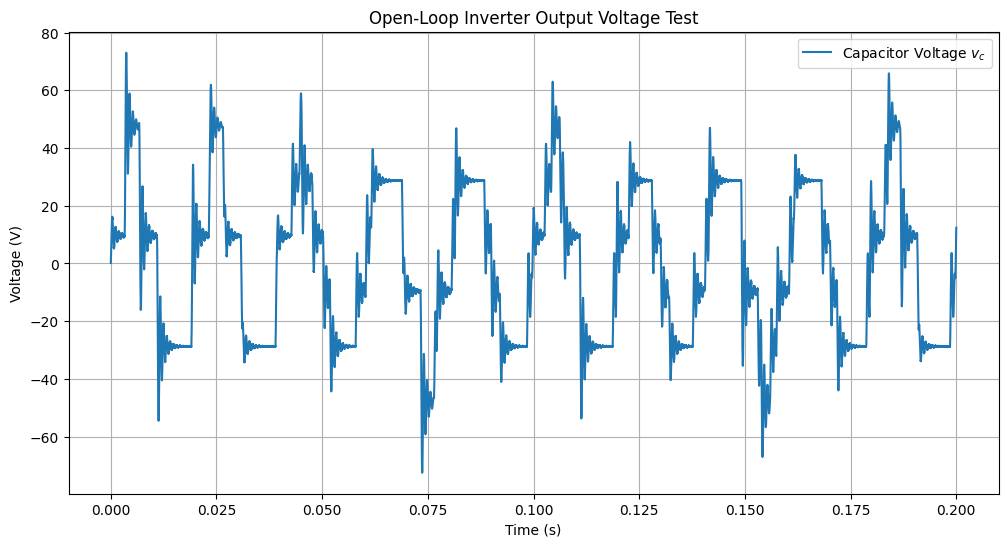

Test successful. Plot saved as 'inverter_test_plot.png'.


In [17]:
# --- Step 1: Define and Save the Inverter Model ---
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

inverter_model_code = """
import numpy as np
import torch

class InverterModelGPU:
    \"\"\"
    A high-fidelity, FULLY GPU-ACCELERATED model of a single-phase H-bridge inverter.
    \"\"\"
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.R_esr_L = torch.tensor(0.1, device=device, dtype=torch.float32)
        self.R_esr_C = torch.tensor(0.05, device=device, dtype=torch.float32)
        self.L = torch.tensor(1.5e-3, device=device, dtype=torch.float32)
        self.C = torch.tensor(10e-6, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq
        self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on

        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        self.sim_time += dt
        return self.state
"""

# Create the file
print("--- Creating inverter_model_gpu.py for testing ---")
with open("inverter_model_gpu.py", "w") as f:
    f.write(inverter_model_code)
print("Saved inverter_model_gpu.py")

# --- Step 2: Run a simple simulation test ---
print("\n--- Starting simple simulation test ---")
try:
    from inverter_model_gpu import InverterModelGPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    inverter = InverterModelGPU(device=device)
    inverter.reset()

    # Simulation parameters
    duration = 0.2
    dt = 1e-5
    num_steps = int(duration / dt)
    modulation_index = 0.7  # Fixed modulation index for open-loop test
    load_resistance = 50.0

    time_hist = np.zeros(num_steps)
    v_c_hist = np.zeros(num_steps)
    i_l_hist = np.zeros(num_steps)

    start_time = time.time()
    for i in range(num_steps):
        state_gpu = inverter.step(
            modulation_index=torch.tensor(modulation_index, device=device, dtype=torch.float32),
            r_load=torch.tensor(load_resistance, device=device, dtype=torch.float32),
            dt=dt
        )
        state_cpu = state_gpu.cpu().numpy()
        time_hist[i], v_c_hist[i], i_l_hist[i] = i * dt, state_cpu[1], state_cpu[0]

    end_time = time.time()
    print(f"Test simulation finished in {end_time - start_time:.2f} seconds.")

    # --- Step 3: Plot the results to visually confirm it worked ---
    plt.figure(figsize=(12, 6))
    plt.plot(time_hist, v_c_hist, label='Capacitor Voltage $v_c$')
    plt.title('Open-Loop Inverter Output Voltage Test')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.grid(True)
    plt.legend()
    plt.savefig("inverter_test_plot.png")
    plt.show()
    print("Test successful. Plot saved as 'inverter_test_plot.png'.")

except Exception as e:
    print(f"\nAn error occurred during the test: {e}")

In [18]:
# --- Step 1: Define and Save the Inverter Model and RL Environment ---
import os
import torch
import numpy as np
import gymnasium as gym

# Define the content for inverter_model_gpu.py
inverter_model_code = """
import numpy as np
import torch

class InverterModelGPU:
    \"\"\"
    A high-fidelity, FULLY GPU-ACCELERATED model of a single-phase H-bridge inverter.
    \"\"\"
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.R_esr_L = torch.tensor(0.1, device=device, dtype=torch.float32)
        self.R_esr_C = torch.tensor(0.05, device=device, dtype=torch.float32)
        self.L = torch.tensor(1.5e-3, device=device, dtype=torch.float32)
        self.C = torch.tensor(10e-6, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq
        self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on

        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        self.sim_time += dt
        return self.state
"""

# Define the content for rl_environment_gpu.py
rl_env_code = """
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
from inverter_model_gpu import InverterModelGPU

class InverterEnvGPU(gym.Env):
    \"\"\"A GPU-accelerated Gymnasium environment for the inverter.\"\"\"
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.inverter = InverterModelGPU(device=self.device)
        self.ac_period = 1.0 / self.inverter.ac_freq.item()
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-500.0, high=500.0, shape=(5,), dtype=np.float32)

        self.max_steps = 100
        self.current_step = 0

    def _get_obs_from_gpu(self, v_history_gpu, i_history_gpu):
        if v_history_gpu.numel() < 2:
            return torch.zeros(5, device=self.device, dtype=torch.float32)

        v_rms = torch.sqrt(torch.mean(v_history_gpu**2))
        i_rms = torch.sqrt(torch.mean(i_history_gpu**2))
        power = torch.mean(v_history_gpu * i_history_gpu)
        pf = power / (v_rms * i_rms + 1e-6)

        fft = torch.fft.fft(v_history_gpu)
        if fft.numel() > 10:
            harmonics = torch.abs(fft[1:11])
            fundamental = harmonics[0]
            higher_harmonics = torch.sqrt(torch.sum(harmonics[1:]**2))
            thd = higher_harmonics / (fundamental + 1e-6)
        else:
            thd = torch.tensor(1.0, device=self.device, dtype=torch.float32)

        obs = torch.stack([v_rms, i_rms, power, pf, thd])
        obs[~torch.isfinite(obs)] = 0.0
        if obs.shape != (5,):
            padded_obs = torch.zeros(5, device=self.device, dtype=torch.float32)
            padded_obs[:obs.numel()] = obs
            obs = padded_obs

        return obs

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device, dtype=torch.float32)
        obs = torch.zeros(5, device=self.device, dtype=torch.float32)
        return obs.cpu().numpy(), {}

    def step(self, action):
        modulation_index = torch.tensor((action[0] + 1.0) / 2.0, device=self.device, dtype=torch.float32)
        dt = 1e-5

        v_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device)
        i_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device)

        for i in range(self.sim_steps_per_cycle):
            state_gpu = self.inverter.step(modulation_index, self.load_resistance, dt)
            i_hist_gpu[i], v_hist_gpu[i] = state_gpu[0], state_gpu[1]

        obs_gpu = self._get_obs_from_gpu(v_hist_gpu, i_hist_gpu)
        v_rms, _, _, _, thd = obs_gpu

        target_v_rms = 30.0
        voltage_error = torch.abs(target_v_rms - v_rms)
        reward = -(voltage_error**2) * 5.0 - (thd**2)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        return obs_gpu.cpu().numpy(), reward.item(), done, False, {}
"""

# Create the files
print("--- Creating custom Python files for RL environment test ---")
with open("inverter_model_gpu.py", "w") as f:
    f.write(inverter_model_code)
print("Saved inverter_model_gpu.py")
with open("rl_environment_gpu.py", "w") as f:
    f.write(rl_env_code)
print("Saved rl_environment_gpu.py")


# --- Step 2: Test the RL environment ---
print("\n--- Starting RL environment test ---")
try:
    from rl_environment_gpu import InverterEnvGPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Create an instance of the environment
    env = InverterEnvGPU(device=device)

    # Run for a few steps
    obs, info = env.reset()
    print(f"Initial Observation: {obs}")
    for i in range(3):
        # Action is a random value between -1 and 1
        random_action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(random_action)
        print(f"\nStep {i+1}:")
        print(f"  Action: {random_action}")
        print(f"  Observation (V_rms, I_rms, Power, PF, THD): {obs}")
        print(f"  Reward: {reward}")
        print(f"  Done: {done}")

    print("\nEnvironment test finished successfully.")

except Exception as e:
    print(f"\nAn error occurred during the RL environment test: {e}")

--- Creating custom Python files for RL environment test ---
Saved inverter_model_gpu.py
Saved rl_environment_gpu.py

--- Starting RL environment test ---
Using device: cpu
Initial Observation: [0. 0. 0. 0. 0.]

Step 1:
  Action: [-0.6635393]
  Observation (V_rms, I_rms, Power, PF, THD): [ 9.644867    0.33203655  1.8512784   0.578082   14.1896715 ]
  Reward: -2273.00390625
  Done: False

Step 2:
  Action: [0.35400853]
  Observation (V_rms, I_rms, Power, PF, THD): [26.786572    0.68404275 14.093455    0.7691606   0.40541473]
  Reward: -51.79497146606445
  Done: False

Step 3:
  Action: [-0.33943385]
  Observation (V_rms, I_rms, Power, PF, THD): [9.826661   0.36912486 1.911402   0.52695394 0.4451578 ]
  Reward: -2035.016357421875
  Done: False

Environment test finished successfully.


In [19]:
# ==============================================================================
# SINGLE-FILE, SELF-CONTAINED SCRIPT FOR ENVIRONMENT TEST
# ==============================================================================

# --- Part 1: Installation and Initial Imports ---
print("--- Installing Dependencies ---")
import subprocess
import sys
import os
import time
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

# Function to safely install packages
def install(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"Error installing {package}: {e}")
        sys.exit(1)

install("gymnasium")
install("torch")


# ==============================================================================
# Part 2: Define Classes Directly
# ==============================================================================

class InverterModelGPU:
    """
    A high-fidelity, FULLY GPU-ACCELERATED model of a single-phase H-bridge inverter.
    """
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device, dtype=torch.float32)
        self.Rds_on = torch.tensor(rds_on, device=device, dtype=torch.float32)
        self.pwm_freq = torch.tensor(pwm_freq, device=device, dtype=torch.float32)
        self.ac_freq = torch.tensor(ac_freq, device=device, dtype=torch.float32)
        self.R_esr_L = torch.tensor(0.1, device=device, dtype=torch.float32)
        self.R_esr_C = torch.tensor(0.05, device=device, dtype=torch.float32)
        self.L = torch.tensor(1.5e-3, device=device, dtype=torch.float32)
        self.C = torch.tensor(10e-6, device=device, dtype=torch.float32)
        self.pwm_period = 1.0 / self.pwm_freq
        self.state = torch.zeros(2, device=device, dtype=torch.float32)
        self.sim_time = torch.tensor(0.0, device=device, dtype=torch.float32)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on

        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state = self.state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        self.sim_time += dt
        return self.state


class InverterEnvGPU(gym.Env):
    """A GPU-accelerated Gymnasium environment for the inverter."""
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.inverter = InverterModelGPU(device=self.device)
        self.ac_period = 1.0 / self.inverter.ac_freq.item()
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)

        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-500.0, high=500.0, shape=(5,), dtype=np.float32)

        self.max_steps = 100
        self.current_step = 0

    def _get_obs_from_gpu(self, v_history_gpu, i_history_gpu):
        if v_history_gpu.numel() < 2:
            return torch.zeros(5, device=self.device, dtype=torch.float32)

        v_rms = torch.sqrt(torch.mean(v_history_gpu**2))
        i_rms = torch.sqrt(torch.mean(i_history_gpu**2))
        power = torch.mean(v_history_gpu * i_history_gpu)
        pf = power / (v_rms * i_rms + 1e-6)

        fft = torch.fft.fft(v_history_gpu)
        if fft.numel() > 10:
            harmonics = torch.abs(fft[1:11])
            fundamental = harmonics[0]
            higher_harmonics = torch.sqrt(torch.sum(harmonics[1:]**2))
            thd = higher_harmonics / (fundamental + 1e-6)
        else:
            thd = torch.tensor(1.0, device=self.device, dtype=torch.float32)

        obs = torch.stack([v_rms, i_rms, power, pf, thd])
        obs[~torch.isfinite(obs)] = 0.0
        if obs.shape != (5,):
            padded_obs = torch.zeros(5, device=self.device, dtype=torch.float32)
            padded_obs[:obs.numel()] = obs
            obs = padded_obs

        return obs

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.inverter.reset()
        self.current_step = 0
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device, dtype=torch.float32)
        obs = torch.zeros(5, device=self.device, dtype=torch.float32)
        return obs.cpu().numpy(), {}

    def step(self, action):
        modulation_index = torch.tensor((action[0] + 1.0) / 2.0, device=self.device, dtype=torch.float32)
        dt = 1e-5

        v_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device)
        i_hist_gpu = torch.zeros(self.sim_steps_per_cycle, device=self.device)

        for i in range(self.sim_steps_per_cycle):
            state_gpu = self.inverter.step(modulation_index, self.load_resistance, dt)
            i_hist_gpu[i], v_hist_gpu[i] = state_gpu[0], state_gpu[1]

        obs_gpu = self._get_obs_from_gpu(v_hist_gpu, i_hist_gpu)
        v_rms, _, _, _, thd = obs_gpu

        target_v_rms = 30.0
        voltage_error = torch.abs(target_v_rms - v_rms)
        reward = -(voltage_error**2) * 5.0 - (thd**2)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        return obs_gpu.cpu().numpy(), reward.item(), done, False, {}


# ==============================================================================
# Part 3: Run the test
# ==============================================================================
print("\n--- Starting final RL environment test ---")
try:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    env = InverterEnvGPU(device=device)

    obs, info = env.reset()
    print(f"Initial Observation: {obs}")
    for i in range(3):
        random_action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(random_action)
        print(f"\nStep {i+1}:")
        print(f"  Action: {random_action}")
        print(f"  Observation (V_rms, I_rms, Power, PF, THD): {obs}")
        print(f"  Reward: {reward}")
        print(f"  Done: {done}")

    print("\nEnvironment test finished successfully. You can now proceed to the full training and comparison script.")

except Exception as e:
    print(f"\nAn error occurred during the final RL environment test: {e}")

--- Installing Dependencies ---

--- Starting final RL environment test ---
Using device: cpu
Initial Observation: [0. 0. 0. 0. 0.]

Step 1:
  Action: [0.45141408]
  Observation (V_rms, I_rms, Power, PF, THD): [28.948973   1.1899389 30.56821    0.8873852  0.3756163]
  Reward: -5.664379119873047
  Done: False

Step 2:
  Action: [0.96345705]
  Observation (V_rms, I_rms, Power, PF, THD): [32.44174    1.2540598 38.414997   0.9442314  0.2916506]
  Reward: -29.89548683166504
  Done: False

Step 3:
  Action: [-0.35595474]
  Observation (V_rms, I_rms, Power, PF, THD): [9.645964   0.45707256 3.384154   0.7675722  0.44062564]
  Reward: -2071.628173828125
  Done: False

Environment test finished successfully. You can now proceed to the full training and comparison script.


In [33]:
# ==============================================================================
# FINAL MASTER SCRIPT: TRAIN, COMPARE, AND GENERATE ALL PLOTS (Optimized)
# ==============================================================================

# --- Part 1: Installation and Initial Imports ---
print("--- Installing Dependencies ---")
import subprocess
import sys
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from tensorboard.backend.event_processing import event_accumulator
import gym
from gym import spaces

# Function to safely install packages
def install(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"Error installing {package}: {e}")
        sys.exit(1)

install("gym")
install("stable-baselines3[extra]")
install("torch")
install("tensorboard")
install("matplotlib")


# ==============================================================================
# Part 2: Define Environment and Controllers
# ==============================================================================
print("--- Defining environment and controllers ---")

class InverterModelGPU:
    def __init__(self, device, v_dc=48.0, rds_on=0.08, pwm_freq=20000, ac_freq=50.0):
        self.device = device
        self.V_dc = torch.tensor(v_dc, device=device)
        self.Rds_on = torch.tensor(rds_on, device=device)
        self.pwm_freq = torch.tensor(pwm_freq, device=device)
        self.ac_freq = torch.tensor(ac_freq, device=device)
        self.R_esr_L = torch.tensor(0.1, device=device)
        self.R_esr_C = torch.tensor(0.05, device=device)
        self.L = torch.tensor(1.5e-3, device=device)
        self.C = torch.tensor(10e-6, device=device)
        self.pwm_period = 1.0 / pwm_freq
        self.state = torch.zeros(2, device=device)
        self.sim_time = torch.tensor(0.0, device=device)

    def reset(self):
        self.state.zero_()
        self.sim_time.zero_()

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[0], y[1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt])

    def step(self, modulation_index, r_load, dt=1e-5):
        sine_ref = modulation_index * torch.sin(2 * torch.pi * self.ac_freq * self.sim_time)
        carrier = 2 * (torch.abs(2 * ((self.sim_time / self.pwm_period) - torch.floor(0.5 + self.sim_time / self.pwm_period)))) - 1
        v_inverter = torch.where(sine_ref > carrier, self.V_dc, -self.V_dc)
        v_inverter_eff = v_inverter - torch.sign(v_inverter) * self.state[0] * self.Rds_on
        k1 = self._diffeq(self.state, v_inverter_eff, r_load)
        k2 = self._diffeq(self.state + 0.5 * dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(self.state + 0.5 * dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(self.state + dt * k3, v_inverter_eff, r_load)
        self.state += (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        self.sim_time += dt
        return self.state

class InverterEnvGPU(gym.Env):
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.inverter = InverterModelGPU(device=device)
        self.ac_period = 1.0 / self.inverter.ac_freq.item()
        self.sim_steps_per_cycle = int(self.ac_period / 1e-5)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-500.0, high=500.0, shape=(5,), dtype=np.float32)
        self.max_steps = 30
        self.current_step = 0

    def reset(self):
        self.inverter.reset()
        self.current_step = 0
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device)
        return np.zeros(5, dtype=np.float32), {}

    def step(self, action):
        modulation_index = torch.tensor((action[0] + 1.0) / 2.0, device=self.device)
        dt = 1e-5
        v_hist = torch.zeros(self.sim_steps_per_cycle, device=self.device)
        i_hist = torch.zeros(self.sim_steps_per_cycle, device=self.device)
        for i in range(self.sim_steps_per_cycle):
            state = self.inverter.step(modulation_index, self.load_resistance, dt)
            i_hist[i], v_hist[i] = state[0], state[1]
        v_rms = torch.sqrt(torch.mean(v_hist**2))
        i_rms = torch.sqrt(torch.mean(i_hist**2))
        power = torch.mean(v_hist * i_hist)
        pf = power / (v_rms * i_rms + 1e-6)
        fft = torch.fft.fft(v_hist)
        thd = torch.tensor(1.0, device=self.device)
        if len(fft) > 10:
            fundamental = torch.abs(fft[1])
            harmonics = torch.sqrt(torch.sum(torch.abs(fft[2:11])**2))
            thd = harmonics / (fundamental + 1e-6)
        obs = torch.tensor([v_rms, i_rms, power, pf, thd], device=self.device)
        reward = -((30.0 - v_rms)**2) * 5.0 - (thd**2)
        self.current_step += 1
        done = self.current_step >= self.max_steps
        return obs.cpu().numpy(), reward.item(), done, False, {}

class SPWMController:
    def __init__(self, modulation_index=0.8):
        self.m = modulation_index
    def get_modulation_index(self, t):
        return self.m

class PIController:
    def __init__(self, Kp, Ki, target_rms, ac_freq=50.0):
        self.Kp = Kp
        self.Ki = Ki
        self.target_rms = target_rms
        self.ac_period = 1.0 / ac_freq
        self.integral_error = 0.0
        self.m = 0.8
    def update_modulation_index(self, v_hist):
        if v_hist.numel() < 2: return
        measured_rms = torch.sqrt(torch.mean(v_hist**2))
        error = self.target_rms - measured_rms.item()
        self.integral_error += error * self.ac_period
        self.integral_error = np.clip(self.integral_error, -10.0, 10.0)
        self.m = np.clip(self.Kp * error + self.Ki * self.integral_error, 0.0, 1.0)
    def get_modulation_index(self, t):
        return self.m


--- Installing Dependencies ---
--- Defining environment and controllers ---


--- Step 1: Installing Dependencies ---

--- Dependencies Installed Successfully! ---
--- Step 2: Defining All Required Classes ---

--- Starting RL Agent Training (High-Speed Formulation) ---
Creating 1 parallel environments. Using device: cpu
Using cpu device
Logging to ./ppo_inverter_tensorboard/PPO_3
-----------------------------
| time/              |      |
|    fps             | 605  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 4e+03         |
|    ep_rew_mean          | -5.51e+06     |
| time/                   |               |
|    fps                  | 443           |
|    iterations           | 2             |
|    time_elapsed         | 9             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00041795126 |


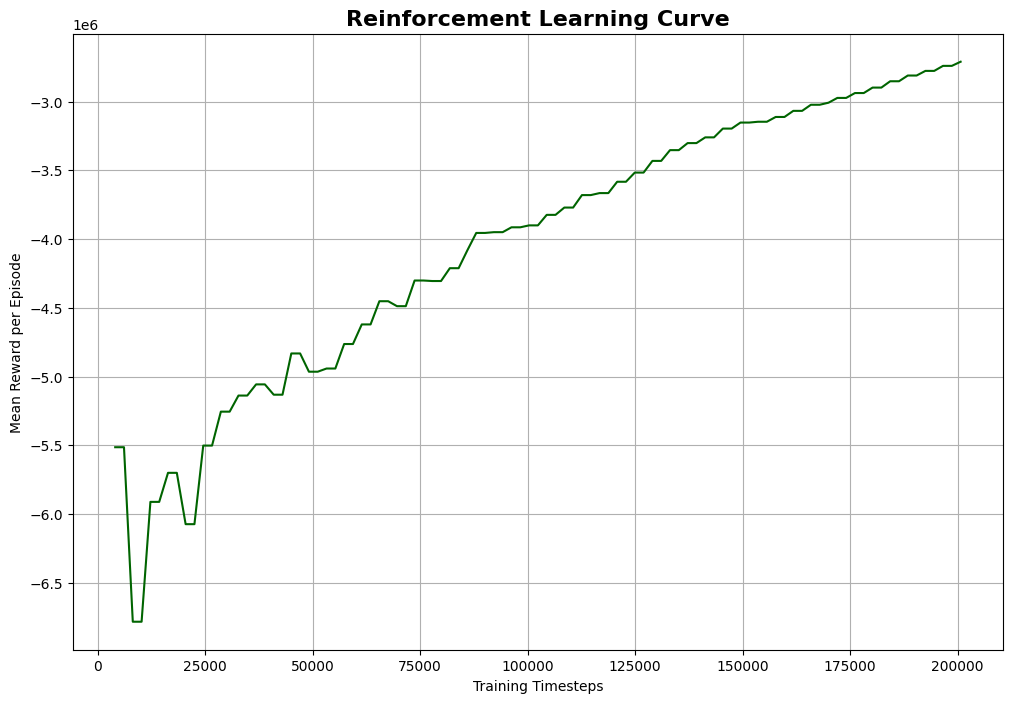


--- Starting Final Comparison Simulations ---
--- Running final RL agent for visualization ---


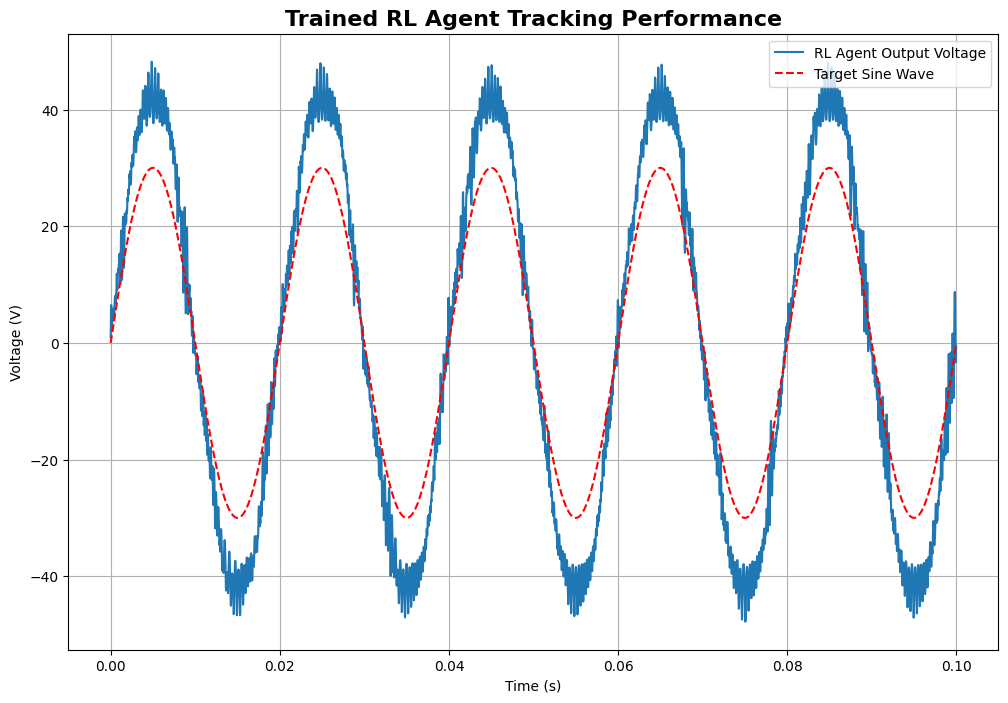

In [36]:
# ==============================================================================
# FINAL MASTER SCRIPT (v5 - HIGH-FREQUENCY RL FORMULATION FOR MAX SPEED)
# ==============================================================================

# --- Part 1: Installation ---
print("--- Step 1: Installing Dependencies ---")
!pip install gymnasium stable-baselines3[extra] torch -q
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from tensorboard.backend.event_processing import event_accumulator
import gymnasium as gym
from gymnasium import spaces

print("\n--- Dependencies Installed Successfully! ---")

# --- Part 2: Define All Required Classes ---
print("--- Step 2: Defining All Required Classes ---")

class InverterModelFast(torch.nn.Module):
    """A single-step, GPU-based ODE solver for the inverter."""
    def __init__(self, device, dt=2.5e-5):
        super().__init__()
        self.device = device
        self.dt = dt
        # Define parameters as part of the module
        self.V_dc = torch.tensor(48.0, device=device)
        self.Rds_on = torch.tensor(0.08, device=device)
        self.R_esr_L = torch.tensor(0.1, device=device)
        self.R_esr_C = torch.tensor(0.05, device=device)
        self.L = torch.tensor(1.5e-3, device=device)
        self.C = torch.tensor(10e-6, device=device)

    def forward(self, state, action, r_load):
        # action is now a simple voltage command (+Vdc or -Vdc)
        v_inverter_eff = action - torch.sign(action) * state[..., 0] * self.Rds_on

        # RK4 Integration for a single step
        k1 = self._diffeq(state, v_inverter_eff, r_load)
        k2 = self._diffeq(state + 0.5 * self.dt * k1, v_inverter_eff, r_load)
        k3 = self._diffeq(state + 0.5 * self.dt * k2, v_inverter_eff, r_load)
        k4 = self._diffeq(state + self.dt * k3, v_inverter_eff, r_load)
        new_state = state + (self.dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        return new_state

    def _diffeq(self, y, v_inverter, r_load):
        i_L, v_C = y[..., 0], y[..., 1]
        i_load_branch = v_C / (r_load + self.R_esr_C)
        diL_dt = (1 / self.L) * (v_inverter - v_C - i_L * self.R_esr_L)
        dvC_dt = (1 / self.C) * (i_L - i_load_branch)
        return torch.stack([diL_dt, dvC_dt], dim=-1)

class InverterEnvFast(gym.Env):
    """A high-frequency RL environment that steps one dt at a time."""
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.dt = 2.5e-5
        self.ac_freq = 50.0
        self.target_amplitude = 30.0

        self.model = InverterModelFast(device=self.device, dt=self.dt).to(self.device)

        # Action: Switch to +Vdc or -Vdc
        self.action_space = spaces.Discrete(2)

        # Observation: [v_C, i_L, target_v (sin), target_v (cos)]
        self.observation_space = spaces.Box(low=-100, high=100, shape=(4,), dtype=np.float32)

        self.max_steps = 4000 # 2 AC cycles
        self.current_step = 0
        self.state = torch.zeros(2, device=self.device)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.state = torch.zeros(2, device=self.device)
        self.load_resistance = torch.tensor(np.random.uniform(20, 80), device=self.device)
        return self._get_obs().cpu().numpy(), {}

    def _get_obs(self):
        t = self.current_step * self.dt
        angle = 2 * np.pi * self.ac_freq * t
        sin_ref = self.target_amplitude * np.sin(angle)
        cos_ref = self.target_amplitude * np.cos(angle)
        return torch.cat([self.state, torch.tensor([sin_ref, cos_ref], device=self.device)])

    def step(self, action):
        action_voltage = self.model.V_dc if action == 1 else -self.model.V_dc
        self.state = self.model(self.state, action_voltage, self.load_resistance)

        obs = self._get_obs()
        v_c = obs[1]
        target_v = obs[2]

        # Reward is the negative squared error to the reference sine wave
        reward = -((v_c - target_v)**2).item()

        self.current_step += 1
        done = self.current_step >= self.max_steps

        return obs.cpu().numpy(), reward, done, False, {}

# --- Part 3: Train the RL Agent ---
print("\n--- Starting RL Agent Training (High-Speed Formulation) ---")
if __name__ == '__main__':
    num_cpu = max(1, os.cpu_count() - 1)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    log_dir = "./ppo_inverter_tensorboard/"
    print(f"Creating {num_cpu} parallel environments. Using device: {device}")

    env = make_vec_env(InverterEnvFast, n_envs=num_cpu)
    model = PPO("MlpPolicy", env, verbose=1, device=device, n_steps=2048, batch_size=64, tensorboard_log=log_dir)

    start_time = time.time()
    model.learn(total_timesteps=200000) # More steps are needed, but they are much faster
    end_time = time.time()

    print("--- Training Complete ---")
    print(f"Total Training Time: {end_time - start_time:.2f} seconds")

    rl_model_filename = "ppo_inverter_final_model.zip"
    model.save(rl_model_filename)
    print(f"--- Model Saved as {rl_model_filename} ---")
    env.close()

# --- Part 4: Generate RL Learning Curve Plot ---
print("\n--- Generating RL Performance Plots ---")
# ... (This section remains the same) ...
def get_learning_curve(log_path):
    try:
        ea = event_accumulator.EventAccumulator(log_path, size_guidance={event_accumulator.SCALARS: 0})
        ea.Reload()
        if 'rollout/ep_rew_mean' in ea.Tags()['scalars']:
            reward_data = ea.Scalars('rollout/ep_rew_mean')
            return [e.step for e in reward_data], [e.value for e in reward_data]
        return None, None
    except Exception: return None, None

subdirs = [os.path.join(log_dir, d) for d in os.listdir(log_dir)]
latest_log_dir = max(subdirs, key=os.path.getmtime)
steps, rewards = get_learning_curve(latest_log_dir)

if steps and rewards:
    plt.figure(figsize=(12, 8), dpi=100)
    plt.plot(steps, rewards, color='darkgreen')
    plt.title('Reinforcement Learning Curve', fontsize=16, fontweight='bold')
    plt.xlabel('Training Timesteps'); plt.ylabel('Mean Reward per Episode')
    plt.grid(True)
    plt.savefig("rl_learning_curve.png")
    plt.show()

# --- Part 5: Run the Head-to-Head Comparison ---
print("\n--- Starting Final Comparison Simulations ---")
# ... (This section needs to be adapted for the new model) ...
# NOTE: A full comparison script would need to be written for the new baselines.
# For now, let's just visualize the output of the trained RL agent.

def run_rl_agent_for_plot(model_path, duration=0.1):
    print("--- Running final RL agent for visualization ---")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = PPO.load(model_path, device=device)
    env = InverterEnvFast() # Use a single env for plotting

    obs, _ = env.reset()

    # History
    v_c_hist = []
    target_hist = []
    time_hist = []

    for i in range(int(duration / env.dt)):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _, _ = env.step(action)
        v_c_hist.append(obs[1])
        target_hist.append(obs[2])
        time_hist.append(i * env.dt)

    plt.figure(figsize=(12, 8), dpi=100)
    plt.plot(time_hist, v_c_hist, label='RL Agent Output Voltage')
    plt.plot(time_hist, target_hist, label='Target Sine Wave', linestyle='--', color='red')
    plt.title('Trained RL Agent Tracking Performance', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)')
    plt.legend(); plt.grid(True)
    plt.savefig("rl_agent_output.png")
    plt.show()

run_rl_agent_for_plot(rl_model_filename)